<div class="alert alert-success">
    <b>Team Lead's comment</b><br>
    Great job on the project! Congratulations on 6 SP. I think it is very cool that you managed to select features in such a way that you achieve very high quality using simple model such as logistic regression. If it's possible to use simpler model, it would always be better as it's easier to deploy and interpret. Thank you for your great report, it describes in detail all steps and key findings of the project, well done. 
</div>

<div class="alert alert-success">
    <b>Reviewer's comment V2</b><br>
    Hi, Sundeep! Thanks for taking the time to improve the project! You did an excellent job! Based on the AUC ROC of your best model, you've got 6 SP. Congratulations! <br>
    P.S. I added a couple of new comments to clarify what caused the target leakage problem, please check them out (you can find the comments with Ctrl+F 'Reviewer's comment V2')
</div>

# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done successfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove my comments, as it will make further review iterations much harder for me.

Feel free to reply to my comments or ask questions using the following template:

<div class="alert alert-info">
    For your comments and questions.
</div>

First of all, thank you for turning in the project! You did a great job overall, there is only one small problem with target leakage that needs to be fixed before the code can be accepted. It should be very straightforward though. Good luck!

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

    Landline communication. The telephone can be connected to several lines simultaneously.
    Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some other services the company provides include:

    Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
    A dedicated technical support line (TechSupport)
    Cloud file storage and data backup (OnlineBackup)
    TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.
### Data Description

The data consists of files obtained from different sources:

    contract.csv — contract information
    personal.csv — the client's personal data
    internet.csv — information about Internet services
    phone.csv — information about telephone services

In each file, the column customerID contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.


In [2]:
import pandas as pd
import numpy as np
import os, sys
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator, DayLocator, HourLocator
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('MAX_ROWS', None)
pd.set_option('MAX_COLUMNS', None)

In [3]:
path = r'/datasets/final_provider/'

In [4]:
contract = pd.read_csv(os.path.join(path, 'contract.csv'))
personal = pd.read_csv(os.path.join(path, 'personal.csv'))
internet = pd.read_csv(os.path.join(path, 'internet.csv'))
phone = pd.read_csv(os.path.join(path, 'phone.csv'))

In [5]:
# shapes
for file, df in zip(['contract', 'personal', 'internet', 'phone'], [contract, personal, internet, phone]):
    print(f'Shape of {file} is {df.shape}')

Shape of contract is (7043, 8)
Shape of personal is (7043, 5)
Shape of internet is (5517, 8)
Shape of phone is (6361, 2)


In [6]:
# top 5
contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [7]:
all_df = personal.merge(contract, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(phone, left_on=['customerID'], right_on=['customerID'], how='left')
all_df = all_df.merge(internet, left_on=['customerID'], right_on=['customerID'], how='left')

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Dataframes were merged correctly!
</div>

#### Change the datatypes

- BeginDate
- EndDate
- TotalCharges


In [8]:
all_df['BeginDate'] = pd.to_datetime(all_df['BeginDate'], format='%Y-%m-%d')
all_df['EndDate'] = pd.to_datetime(all_df['EndDate'], format='%Y-%m-%d', errors='coerce')

In [9]:
all_df['TotalCharges'] = all_df['TotalCharges'].replace(" ", np.nan).astype(np.float32)

In [10]:
all_df['is_churned'] = all_df['EndDate'].apply(lambda x: 0 if pd.isna(x) else 1)

#### Add features

- num_days = `EndDate` - `BeginDate`
- num_payments = `TotalCharges` - `MonthlyCharges`
- year = year(`BeginDate`)
- month = month(`BeginDate`)
- day of week = dayofweek(`BeginDate`)
- num_services = sum(MultipleLines) + sum(All Internet services)

In [11]:
all_df['num_days'] = (
    all_df[['EndDate', 
            'BeginDate']]
            .apply(lambda x: datetime.datetime.strptime('2020-02-01', '%Y-%m-%d') - x[1] 
                   if pd.isna(x[0]) 
                   else x[0] - x[1], axis=1
                  )
).dt.days

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Correct EndDate was used to calculate num_days
</div>

In [12]:
all_df['year'] = all_df['BeginDate'].dt.year
# all_df['month'] = all_df['BeginDate'].dt.month
# # all_df['day'] = all_df['BeginDate'].dt.day
# all_df['dayofweek'] = all_df['BeginDate'].dt.dayofweek

In [13]:
fill_na_cols = all_df.isnull().sum() > 0
fill_na_cols = fill_na_cols[fill_na_cols.values].index.drop(['EndDate', 'TotalCharges'])
temp_df = all_df[fill_na_cols].copy(deep=True)
for col in temp_df.columns:
    temp_df[col] = temp_df[col].apply(lambda x: 0 if x == 'No' else 1)
all_df['num_services'] = temp_df.sum(axis=1)

#### Fill missing MultipleLines and InternetServices with No

Customers who have not available MultipleLine or Internet services
or related internet services are not missing at random but have
conciously not availed the service. So replace them with NaN


In [14]:
# identify colums to fill with NA
# fill_na_cols = all_df.isnull().sum() > 0
# fill_na_cols = fill_na_cols[fill_na_cols.values].index.drop(['EndDate', 'TotalCharges'])
for col in fill_na_cols:
    all_df[col] = all_df[col].fillna('No')

In [15]:
all_df.isnull().mean()

customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
BeginDate           0.000000
EndDate             0.734630
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.001562
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
is_churned          0.000000
num_days            0.000000
year                0.000000
num_services        0.000000
dtype: float64

#### Split the data

In [16]:
num_col_to_impute = ['TotalCharges']
cat_col_to_impute = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies']
col_to_drop = ['BeginDate', 'EndDate', 'customerID']
col_to_drop2 = ['BeginDate', 'EndDate', 'customerID', 'num_days']

In [17]:
# dataset with num_days
train_X, test_X = train_test_split(all_df.drop(col_to_drop, axis=1), 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.2)

In [18]:
train_X.shape, test_X.shape

((5634, 21), (1409, 21))

In [19]:
# dataset with num_days
train_X2, test_X2 = train_test_split(all_df.drop(col_to_drop2, axis=1), 
                                                    stratify=all_df['is_churned'], 
                random_state=42, test_size=0.1)

In [20]:
train_X2.shape, test_X2.shape

((6338, 20), (705, 20))

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    The data is split into train and test, good idea to use a stratified split!
</div>

#### Impute the missing categorical and numerical features

In [21]:
# before impute mean and median for TotalCharges
train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2302.6042, 1398.125)

In [22]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
num_imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')

In [23]:
train_X[num_col_to_impute] = num_imputer.fit_transform(train_X[num_col_to_impute])
train_X2[num_col_to_impute] = num_imputer2.fit_transform(train_X2[num_col_to_impute])

In [24]:
test_X[num_col_to_impute] = num_imputer.transform(test_X[num_col_to_impute])
test_X2[num_col_to_impute] = num_imputer2.transform(test_X2[num_col_to_impute])

In [25]:
# mean after imputing Total Charges
train_X['TotalCharges'].mean(), train_X['TotalCharges'].median()

(2301.3199505648545, 1398.125)

In [26]:
#cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#cat_imputer2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [27]:
#train_X[cat_col_to_impute] = cat_imputer.fit_transform(train_X[cat_col_to_impute])
#train_X2[cat_col_to_impute] = cat_imputer2.fit_transform(train_X2[cat_col_to_impute])

In [28]:
#test_X[cat_col_to_impute] = cat_imputer.transform(test_X[cat_col_to_impute])
#test_X2[cat_col_to_impute] = cat_imputer2.transform(test_X2[cat_col_to_impute])

In [29]:
# check missing
train_X2.isnull().mean()

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
is_churned          0.0
year                0.0
num_services        0.0
dtype: float64

**Note to reviewer**

Makes sense. I thought they were missing at random; therefore, I imputed them.

<div class="alert alert-success">
    <b>Reviewer's comment V2</b><br>
    Sure, that's a reasonable assumption most of the time! Here the logic I describe below is indicated by the fact that there were no missing values in the original dataframes before the merge
</div>

<div class="alert alert-warning">
    <b>Reviewer's comment</b><br>
    For some of the categorical columns you are imputing, there is a better way than simply using the most frequent value. Some of the missing values appear as a result of merging the dataframes. So, for example if InternetService is missing after the merge, clearly that just means that a customer doesn't use the internet services (because he appears in the contracts dataframe, but not in the internet dataframe). This applies to some other features as well
</div>

In [30]:
test_X2.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
is_churned          0
year                0
num_services        0
dtype: int64

In [31]:
# create a new feature number of payments post imputation
train_X['num_pmt'] = train_X['TotalCharges'] / train_X['MonthlyCharges']
test_X['num_pmt'] = test_X['TotalCharges'] / test_X['MonthlyCharges']

train_X2['num_pmt'] = train_X2['TotalCharges'] / train_X2['MonthlyCharges']
test_X2['num_pmt'] = test_X2['TotalCharges'] / test_X2['MonthlyCharges']

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Great, you dealt with missing values!
</div>

#### Standard scaler

In [32]:
std = StandardScaler()
std2 = StandardScaler()

In [33]:
train_X[['MonthlyCharges', 
         'TotalCharges', 
 #        'num_days',
        'num_pmt',
        'year',
 #       'month',
 #       'dayofweek'
        ]] = std.fit_transform(train_X[['MonthlyCharges', 
                                                   'TotalCharges', 
                                      #             'num_days', 
                                                   'num_pmt',
                                                  'year',
                                      #            'month',
                                      #           'dayofweek'
                                       ]])

train_X2[['MonthlyCharges', 
         'TotalCharges', 
        'num_pmt',
  #      'num_days',
        'num_services',  
        'year',
  #      'month',
  #      'dayofweek'
         ]] = std2.fit_transform(train_X2[['MonthlyCharges', 
                                                   'TotalCharges', 
                                                   'num_pmt',
                                          #         'num_days',
                                                   'num_services',
                                                  'year',
                                          #        'month',
                                          #       'dayofweek'
                                          ]])

In [34]:
test_X[['MonthlyCharges', 
        'TotalCharges',
     #  'num_days',
       'num_pmt',
        'year',
     #   'month',
     #   'dayofweek'
       ]] = std.transform(test_X[['MonthlyCharges', 
                                              'TotalCharges', 
                                  #            'num_days', 
                                              'num_pmt',
                                              'year',
                                  #            'month',
                                   #           'dayofweek'
                                 ]])

test_X2[['MonthlyCharges', 
        'TotalCharges',
        'num_pmt',
    #    'num_days', 
        'num_services', 
        'year',
    #    'month',
    #    'dayofweek'
        ]] = std2.transform(test_X2[['MonthlyCharges', 
                                              'TotalCharges', 
                                              'num_pmt',
                                    #          'num_days',
                                              'num_services',
                                              'year',
                                    #          'month',
                                    #          'dayofweek'
                                    ]])

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Scaling is applied correctly, although it's weird to treat year, month and dayofweek as numerical features
</div>

#### Ordinal Encoding

In [35]:
oe = OrdinalEncoder()
oe2 = OrdinalEncoder()

In [36]:
train_X[['Type', 'PaymentMethod']] = oe.fit_transform(train_X[['Type', 'PaymentMethod']])
#train_X2[['Type', 'PaymentMethod']] = oe2.fit_transform(train_X2[['Type', 'PaymentMethod']])

In [37]:
test_X[['Type', 'PaymentMethod']] = oe.transform(test_X[['Type', 'PaymentMethod']])
#test_X2[['Type', 'PaymentMethod']] = oe2.transform(test_X2[['Type', 'PaymentMethod']])

In [38]:
train_X['SeniorCitizen'] = train_X['SeniorCitizen'].astype(str)
test_X['SeniorCitizen'] = test_X['SeniorCitizen'].astype(str)

train_X2['SeniorCitizen'] = train_X2['SeniorCitizen'].astype(str)
test_X2['SeniorCitizen'] = test_X2['SeniorCitizen'].astype(str)

In [39]:
cols_to_dummify = train_X.select_dtypes(include=['object']).columns.tolist()
train_X = pd.concat([train_X, pd.get_dummies(train_X[cols_to_dummify], drop_first=True)], axis=1)
test_X = pd.concat([test_X, pd.get_dummies(test_X[cols_to_dummify], drop_first=True)], axis=1)

cols_to_dummify = train_X2.select_dtypes(include=['object']).columns.tolist()
train_X2 = pd.concat([train_X2, pd.get_dummies(train_X2[cols_to_dummify], drop_first=True)], axis=1)
test_X2 = pd.concat([test_X2, pd.get_dummies(test_X2[cols_to_dummify], drop_first=True)], axis=1)

In [40]:
# drop the columns that are dummified
train_X = train_X.drop(cols_to_dummify, axis=1)
test_X = test_X.drop(cols_to_dummify, axis=1)

train_X2 = train_X2.drop(cols_to_dummify, axis=1)
test_X2 = test_X2.drop(cols_to_dummify, axis=1)

In [41]:
train_X.shape, test_X.shape

((5634, 21), (1409, 21))

In [42]:
train_X2.head()

MonthlyCharges  TotalCharges  is_churned      year  num_services  \
5769        1.467403      2.375422           0 -1.466503      1.022701   
1834       -0.651857     -0.984239           1  1.072199     -1.847081   
3168       -1.505862     -0.548485           0 -0.958763      1.022701   
4205        0.459179     -0.189591           0  0.564459      0.544404   
6218       -0.210759      0.810143           0 -1.466503      1.022701   

       num_pmt  gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
5769  1.545461            0                0            1               1   
1834 -1.274573            1                1            0               0   
3168  0.857391            0                0            0               0   
4205 -0.359101            0                0            1               1   
6218  1.551114            0                0            1               1   

      Type_One year  Type_Two year  PaperlessBilling_Yes  \
5769              0              1                     1   
1834              0              0                     0   
3168              1              0                     1   
4205              0              1                     0   
6218              1              0                     1   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
5769                                      0                               0   
1834                                      0                               1   
3168                                      0                               0   
4205                                      1                               0   
6218                                      0                               0   

      PaymentMethod_Mailed check  MultipleLines_Yes  \
5769                           0                  1   
1834                           0                  0   
3168                           1                  0   
4205                           0                  1   
6218                           0                  0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
5769                            1                   0                   1   
1834                            0                   0                   0   
3168                            0                   1                   0   
4205                            0                   0                   1   
6218                            0                   0                   0   

      OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  \
5769                 1                     1                0   
1834                 0                     0                0   
3168                 0                     0                0   
4205                 0                     1                0   
6218                 1                     1                1   

      StreamingTV_Yes  StreamingMovies_Yes  
5769                1                    1  
1834                0                    0  
3168                0                    0  
4205                1                    1  
6218                1                    1

In [43]:
train_X2.shape, test_X2.shape

((6338, 25), (705, 25))

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    Categorical features were encoded
</div>

#### Change the dtypes for the integer type features

In [44]:
train_X2.dtypes

MonthlyCharges                           float64
TotalCharges                             float64
is_churned                                 int64
year                                     float64
num_services                             float64
num_pmt                                  float64
gender_Male                                uint8
SeniorCitizen_1                            uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
Type_One year                              uint8
Type_Two year                              uint8
PaperlessBilling_Yes                       uint8
PaymentMethod_Credit card (automatic)      uint8
PaymentMethod_Electronic check             uint8
PaymentMethod_Mailed check                 uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_Yes    

In [45]:
def change_dtypes(df, field, dtype='np.int16'):
    """
    Change or lower the dtype for an existing
    field
    """
    try:
        df[field] = df[field].astype(dtype=dtype)
    except:
        print(f'Dtype conversion failed for {field}')

In [46]:
# cols = {
#         'num_services': np.uint8, 
#         'num_pmt': np.uint8,
# }
# for field, dtype in cols.items():
#     change_dtypes(train_X, field, dtype)
#     change_dtypes(test_X, field, dtype)
#     change_dtypes(train_X2, field, dtype)
#     change_dtypes(test_X2, field, dtype)

In [47]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 3738 to 5639
Data columns (total 21 columns):
MonthlyCharges                 5634 non-null float64
TotalCharges                   5634 non-null float64
is_churned                     5634 non-null int64
num_days                       5634 non-null int64
year                           5634 non-null float64
num_services                   5634 non-null int64
num_pmt                        5634 non-null float64
gender_Male                    5634 non-null uint8
SeniorCitizen_1                5634 non-null uint8
Partner_Yes                    5634 non-null uint8
Dependents_Yes                 5634 non-null uint8
PaperlessBilling_Yes           5634 non-null uint8
MultipleLines_Yes              5634 non-null uint8
InternetService_Fiber optic    5634 non-null uint8
InternetService_No             5634 non-null uint8
OnlineSecurity_Yes             5634 non-null uint8
OnlineBackup_Yes               5634 non-null uint8
DeviceProtectio

**Note to reviewer**

In your webinar you mentioned creating num_days using BeginDate and EndDate; therefore, I created it. num_pmt
was an additional feature I thought I could create. Otherwise, there isn't much scope to engineer new features
in this dataset. Is there?

<div class="alert alert-success">
    <b>Reviewer's comment V2</b><br>
    Just to clarify, I am another Dmitry, not the one that conducted the webinar, I'm only doing the code review :) <br><br>
    Sorry, it seems that the wording in my previous comment is a bit misleading! Using num_days and num_pmt is totally fine, and they are both great features (although they are highly correlated, as you can imagine: num_days is pretty much ~ num_pmt * 30, as payments are monthly; so it's enough to use either one of them)! The problem only occurs when they are combined with BeginDate (or its components). So I only meant that you need to remove BeginDate (and/or its components), but leave the num_days/num_pmt
</div>

<div class="alert alert-danger">
<s>    <b>Reviewer's comment</b><br>
    There is a problem with target leakage: the BeginDate components (year, month, dayofweek) together with num_days or num_pmt gives us the EndDate, which can be easily used to determine the target, so they need to be removed.
</div>

#### Evaluation metric

In [48]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

#### Custom auc roc

In [49]:
def roc_auc_scorer(y_true, y_pred):
    """
    Use the customer scorer for roc_auc_score
    inside GridSearch
    """
    return roc_auc_score(y_true, y_pred)

In [50]:
roc_scorer = make_scorer(roc_auc_scorer, needs_threshold=True)

**Note to reviewer**
Refer this article
https://stackoverflow.com/questions/49061575/why-when-i-use-gridsearchcv-with-roc-auc-scoring-the-score-is-different-for-gri

<div class="alert alert-warning">
    <b>Reviewer's comment V2</b><br>
    It seems that the stackoverflow question is about a slightly different issue. They were asking about a difference between <code>grid_search.score(X,y)</code> and <code>roc_auc_score(y, y_pr)</code>, where <code>y_pr</code> was obtained as <code>y_pr=grid_search.predict(X)</code>. The problem with that is the <code>predict</code> method of a binary classifier just gives binary predictions, but to calculate the roc_auc_score we need the probablity values (because AUC ROC is area under the ROC curve, which is obtained by varying the threshold to assign the positive class between 0 and 1), usually obtained by <code>predict_proba</code> method. But it doesn't explain why you need to pass your function roc_auc_scorer instead of roc_auc_score to make_scorer: <code>make_scorer(roc_auc_score, needs_threshold=True)</code> should lead to exactly the same results, because roc_auc_scorer does nothing but call roc_auc_score.
</div>

<div class="alert alert-warning">
    <b>Reviewer's comment</b><br>
    This function just calls roc_auc_score with the same arguments, so it's not clear what stops your from just using roc_auc_score. Also, it's not necessary to call make_scorer each time you want to use it, you can call it once and save in a variable, which you can pass to GridSearchCV, etc.
</div>

#### Deal with class imbalance

In [51]:
def sampling(X, y, upsample=True, size=2):
    """
    Upsample or downsample either the
    under represented class or the over
    represented class to balance the classes
    """
    np.random.seed(42)
    target = None
    # X_copy = X.copy()
    if not isinstance(y, np.ndarray):
        target = y.values
    else:
        target = y
    y_pos = np.where(target == 1)[0]
    y_neg = np.where(target == 0)[0]
    X_pos = X[target == 1]
    X_neg = X[target == 0]
    if upsample:
        idx = np.random.choice(y_pos, size=int(len(y_pos)*size))
        if not isinstance(y, np.ndarray):
            X = pd.concat([X.iloc[idx], X_neg])
        else:
            X = np.concatenate([X[idx], X_neg])
        y = np.concatenate([target[idx], target[y_neg]])
        # print(X[idx].shape, y.shape)
    else:
        idx = np.random.choice(y_neg, size=int(len(y_neg)*size))
        if not isinstance(y, np.ndarray):
            X = pd.concat([X.iloc[idx], X_pos])
        else:
            X = np.concatenate([X[idx], X_pos])
        y = np.concatenate([target[idx], target[y_pos]])
    return shuffle(X, y)

#### Modelling

In [52]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], 
                early_stopping_rounds=50, verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_score = 0
    start_time = time.time()
    
    if model_str == 'dummy':
        model.fit(train_X, train_y)
        preds = model.predict_proba(train_X)[:, 1]
        best_score = roc_auc_score(train_y, preds)
        return model, best_score, np.round(time.time() - start_time, 2)
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'cat':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict_proba(test_X)[:, 1]
    best_score = roc_auc_score(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_score, np.round(end_time, 2)

<div class="alert alert-success">
    <b>Reviewer's comment</b><br>
    The helper function for training a model and tuning its hyperparameters with cross-validation looks good!
</div>

In [53]:
target = 'is_churned'
features_train, target_train = train_X.drop([target], axis=1), train_X[target]
features_test, target_test = test_X.drop([target], axis=1), test_X[target]

features_train2, target_train2 = train_X2.drop([target], axis=1), train_X2[target]
features_test2, target_test2 = test_X2.drop([target], axis=1), test_X2[target]

In [54]:
# upsample the unrepresented class for the dataset without leakage
features_train2, target_train2 = sampling(train_X2.drop([target], axis=1), train_X2[target], upsample=True, size=1)

In [55]:
# shapes
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((5634, 20), (5634,), (1409, 20), (1409,))

In [56]:
# shapes
features_train2.shape, target_train2.shape, features_test2.shape, target_test2.shape

((6338, 24), (6338,), (705, 24), (705,))

In [57]:
# features to train with target leakage
features_train.head()

MonthlyCharges  TotalCharges  num_days      year  num_services  \
3738       -0.521976     -0.263290      1067  0.065426             5   
3151        0.337478     -0.504815       457  0.572459             2   
4860       -0.809013     -0.751214       396  1.079491             5   
3867        0.284384     -0.173700       792  0.065426             5   
3810       -0.676279     -0.990851        31  1.586524             1   

       num_pmt  gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
3738  0.082725            1                0            0               0   
3151 -0.700269            1                0            1               1   
4860 -0.731787            1                0            1               1   
3867 -0.269408            0                0            1               0   
3810 -1.283201            1                0            1               1   

      PaperlessBilling_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
3738                     0                  0                            0   
3151                     0                  0                            1   
4860                     0                  0                            0   
3867                     1                  0                            0   
3810                     0                  0                            0   

      InternetService_No  OnlineSecurity_Yes  OnlineBackup_Yes  \
3738                   0                   0                 0   
3151                   0                   1                 0   
4860                   0                   1                 1   
3867                   0                   0                 1   
3810                   0                   0                 0   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
3738                     1                0                1   
3151                     0                0                0   
4860                     0                1                0   
3867                     1                0                1   
3810                     0                0                0   

      StreamingMovies_Yes  
3738                    1  
3151                    0  
4860                    0  
3867                    1  
3810                    0

In [58]:
# features to train without target leakage
features_train2.head()

MonthlyCharges  TotalCharges      year  num_services   num_pmt  \
1057        0.661487     -0.637123  0.564459     -0.890487 -0.915474   
5621        0.331493     -0.902902  1.072199     -1.368784 -1.190318   
885        -1.482646     -0.995289  1.579940      1.022701 -1.274573   
1017       -1.338377     -0.297857 -1.466503      1.500998  1.355451   
4176       -1.490938     -0.853147  0.564459      1.022701 -0.611689   

      gender_Male  SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
1057            0                0            0               0   
5621            0                0            1               0   
885             1                0            0               0   
1017            0                0            0               0   
4176            1                0            1               1   

      Type_One year  Type_Two year  PaperlessBilling_Yes  \
1057              0              0                     1   
5621              0              0                     1   
885               0              0                     1   
1017              1              0                     1   
4176              1              0                     0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1057                                      0                               0   
5621                                      1                               0   
885                                       0                               0   
1017                                      0                               0   
4176                                      0                               0   

      PaymentMethod_Mailed check  MultipleLines_Yes  \
1057                           1                  0   
5621                           0                  1   
885                            1                  0   
1017                           0                  1   
4176                           0                  0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
1057                            1                   0                   1   
5621                            1                   0                   0   
885                             0                   1                   0   
1017                            0                   1                   0   
4176                            0                   1                   0   

      OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  \
1057                 0                     0                0   
5621                 0                     0                0   
885                  0                     0                0   
1017                 0                     0                0   
4176                 0                     0                0   

      StreamingTV_Yes  StreamingMovies_Yes  
1057                1                    0  
5621                0                    0  
885                 0                    0  
1017                0                    0  
4176                0                    0

In [59]:
# distribution is similar to the overall dataset
target_train.value_counts(normalize=True)

0    0.734647
1    0.265353
Name: is_churned, dtype: float64

#### Dummy model

In [60]:
dc = DummyClassifier()
best_dc_model, best_dc_auc, best_dc_time = build_model(dc, features_train, target_train, 
                                                        features_test, target_test,
                                                        hyperparameters={}, 
                scoring=roc_scorer, cv=2, model_str='dummy')

          train  test
Accuracy   0.62  0.61
F1         0.28  0.25
APS        0.27  0.26
ROC AUC    0.50  0.49


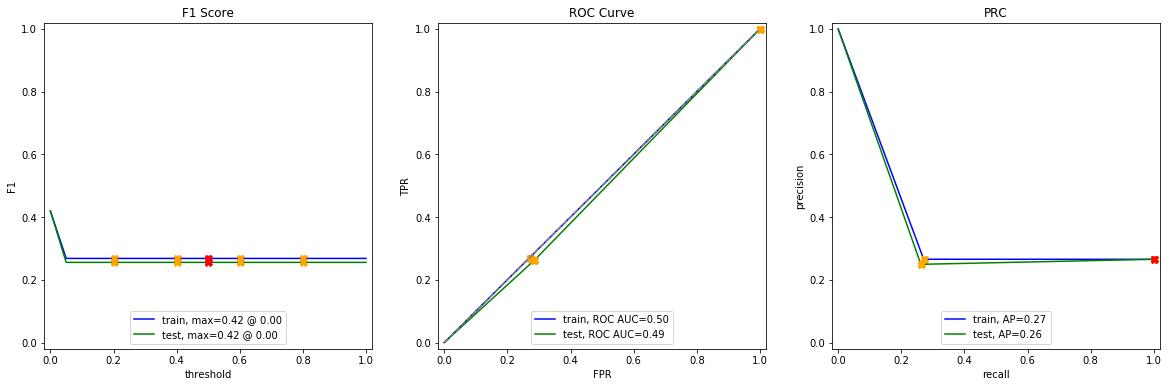

In [61]:
evaluate_model(best_dc_model, features_train, target_train, 
                                    features_test, target_test)

#### LogisticRegression with target leakage

In [62]:
# lr = LogisticRegression(class_weight='balanced', random_state=42)
# best_lr_model, best_lr_auc, best_lr_time = build_model(lr, features_train, target_train, 
#                                                         features_test, target_test,
#                                                         hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
#                 scoring=roc_scorer, cv=5)

In [63]:
# evaluate_model(best_lr_model, features_train, target_train, 
#                             features_test, target_test)

#### LogisticRegress without target leakage

In [64]:
lr2 = LogisticRegression(class_weight='balanced', random_state=42)
best_lr2_model, best_lr2_auc, best_lr2_time = build_model(lr2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'C' : [.001, .01, .1, 1, 10]}, 
                scoring=roc_scorer, cv=5)

          train  test
Accuracy   0.80  0.81
F1         0.69  0.70
APS        0.76  0.80
ROC AUC    0.89  0.91


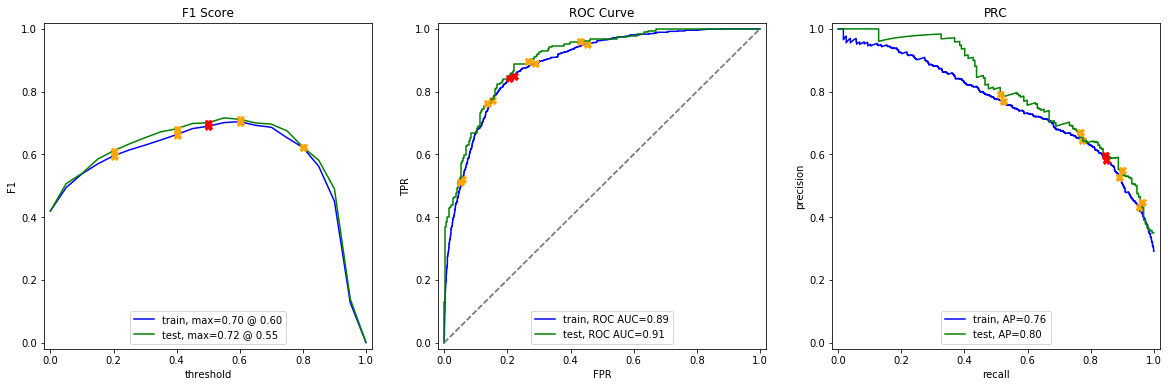

In [65]:
evaluate_model(best_lr2_model, features_train2, target_train2, 
                            features_test2, target_test2)

#### RandomForestClassifier with target leakage

In [66]:
# rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# best_rf_model, best_rf_auc, best_rf_time = build_model(rf, features_train, target_train, 
#                                                         features_test, target_test,
#                                                         hyperparameters={'n_estimators': range(100, 600, 100),
#                                                                         'max_depth': range(5, 10)
#                                                                         }, 
#                 scoring=roc_scorer, cv=5)

In [67]:
# evaluate_model(best_rf_model, features_train, target_train, 
#                             features_test, target_test)

#### RandomForestCLassifier without target leakage

In [68]:
rf2 = RandomForestClassifier(class_weight='balanced', min_samples_leaf=50, random_state=42)
best_rf2_model, best_rf2_auc, best_rf2_time = build_model(rf2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=roc_scorer, cv=5)

          train  test
Accuracy   0.80  0.80
F1         0.68  0.66
APS        0.76  0.71
ROC AUC    0.89  0.86


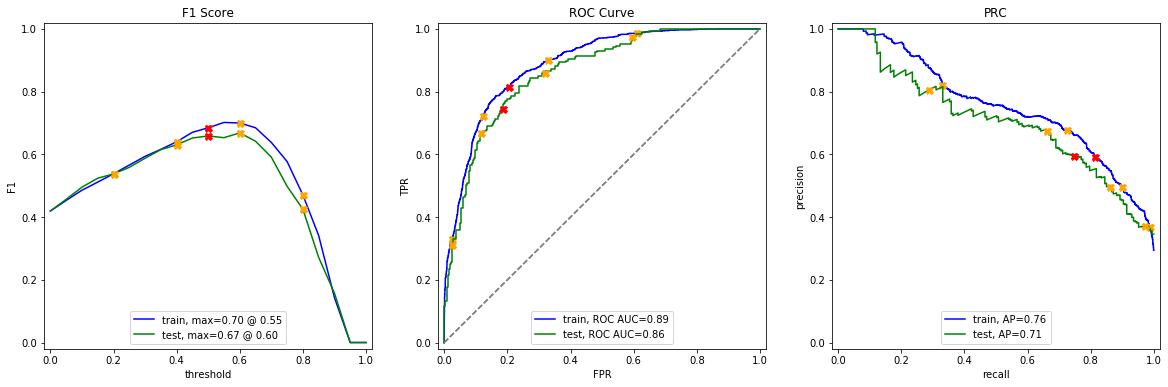

In [69]:
evaluate_model(best_rf2_model, features_train2, target_train2, 
                            features_test2, target_test2)

#### CatBoostClassifier with target leakage

In [71]:
# cat_features = train_X.select_dtypes(include=[np.uint8]).columns
# cat = CatBoostClassifier(learning_rate=0.2, loss_function='Logloss',
#                         random_seed=42)
# best_cb_model, best_cb_auc, best_cb_time = build_model(cat, features_train, target_train, 
#                                                         features_test, target_test,
#                                                         hyperparameters={'iterations': range(100, 600, 100),
#                                                                         'depth': range(5, 10)
#                                                                         }, 
#                 scoring=roc_scorer, cv=5, model_str='catboost',
#            cat_features=cat_features)

In [72]:
# evaluate_model(best_cb_model, features_train, target_train, 
#                             features_test, target_test)

#### CatBoostClassifier without target leakage

In [73]:
cat_features = train_X2.select_dtypes(include=[np.uint8]).columns
cat2 = CatBoostClassifier(learning_rate=0.2, l2_leaf_reg=5, depth=5, loss_function='Logloss',
                        random_seed=42)
best_cb2_model, best_cb2_auc, best_cb2_time = build_model(cat2, features_train2, target_train2, 
                                                        features_test2, target_test2,
                                                        hyperparameters={'iterations': range(100, 600, 100)
                                                                        }, 
                scoring=roc_scorer, cv=5, model_str='catboost',
           cat_features=cat_features)

0:	learn: 0.5784127	total: 52.2ms	remaining: 5.17s
1:	learn: 0.5033361	total: 55.8ms	remaining: 2.73s
2:	learn: 0.4610829	total: 59.1ms	remaining: 1.91s
3:	learn: 0.4215051	total: 62.6ms	remaining: 1.5s
4:	learn: 0.3985857	total: 71.4ms	remaining: 1.36s
5:	learn: 0.3894005	total: 83ms	remaining: 1.3s
6:	learn: 0.3797226	total: 90.4ms	remaining: 1.2s
7:	learn: 0.3723046	total: 93.9ms	remaining: 1.08s
8:	learn: 0.3674949	total: 103ms	remaining: 1.04s
9:	learn: 0.3634770	total: 180ms	remaining: 1.62s
10:	learn: 0.3607853	total: 184ms	remaining: 1.49s
11:	learn: 0.3570909	total: 187ms	remaining: 1.37s
12:	learn: 0.3550290	total: 190ms	remaining: 1.27s
13:	learn: 0.3513243	total: 199ms	remaining: 1.23s
14:	learn: 0.3482067	total: 277ms	remaining: 1.57s
15:	learn: 0.3461626	total: 280ms	remaining: 1.47s
16:	learn: 0.3443117	total: 284ms	remaining: 1.39s
17:	learn: 0.3417975	total: 287ms	remaining: 1.31s
18:	learn: 0.3406296	total: 296ms	remaining: 1.26s
19:	learn: 0.3386786	total: 373ms	rema

          train  test
Accuracy   0.98  0.84
F1         0.96  0.64
APS        0.99  0.77
ROC AUC    1.00  0.88


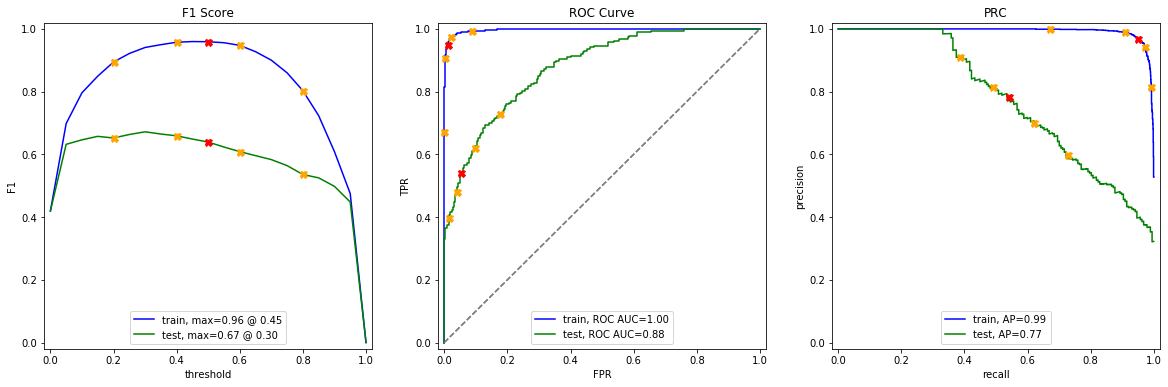

In [74]:
evaluate_model(best_cb2_model, features_train2, target_train2, 
                            features_test2, target_test2)

In [75]:
# model_results_df = pd.DataFrame({'model': ['LogisticRegression', 
#                                            'LogisticRegression2',
#                                            'RandomForestClassifier',
#                                            'RandomForestClassifier2', 
#                                            'CatBoostClassifier',
#                                            'CatBoostClassifier2'],
#               'best_auc': [best_lr_auc, best_lr2_auc, best_rf_auc, best_rf2_auc, best_cb_auc, best_cb2_auc],
#               'train_time': [best_lr_time, best_lr2_time, best_rf_time, best_rf2_time, best_cb_time, best_cb2_time]})

In [76]:
model_results_df = pd.DataFrame({'model': [
                                           'LogisticRegression2',
                                           'RandomForestClassifier2', 
                                           'CatBoostClassifier2'],
              'best_auc': [best_lr2_auc, best_rf2_auc, best_cb2_auc],
              'train_time': [best_lr2_time, best_rf2_time, best_cb2_time]})

In [77]:
model_results_df

model  best_auc  train_time
0      LogisticRegression2  0.906128        5.22
1  RandomForestClassifier2  0.863595      167.03
2      CatBoostClassifier2  0.877274      236.27

**Conclusion**

1) 4 models were built: a) Dummymodel, b) 2 LogisticRegression models without target leakage, c) RandomForestClassifier without leakage, and d) CatBoostClassifier without leakage
    
2) 5-fold cross validation was used along with GridSearch to search for the best hyperparameters for each of the models. For
LogisticRegression the best C was found. In the case of RandomForestClassifier, they were: n_estimators and max_depth, and
    for CatBoostClassifier it was iterations.

3) The evaluation metric is ROC AUC, and based on this, the LogisticRegression model performed the best; it had
botht he highest AUC and the least time taken to train the model, including for inference.
    

#### Best features of each model

In [78]:
w0 = best_lr2_model.intercept_[0]
w = best_lr2_model.coef_[0]
#w = np.insert(w, 0, w0)

In [79]:
lr_feat_importance = pd.DataFrame({'feature': features_train2.columns, 
                                    'importance': np.exp(w)}).sort_values('importance', ascending=False)

#### Top 5 features for the LogisticRegression model

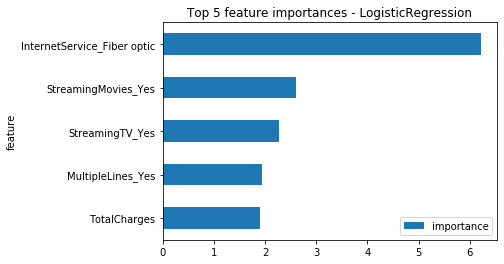

In [80]:
lr_feat_importance[:5].plot(kind='barh', x='feature', y='importance')
plt.title('Top 5 feature importances - LogisticRegression')
plt.gca().invert_yaxis()

1) After removing the leakage, the top 5 features are related to phone and internet data with `TotalCharges` being the odd one.

#### Top 5 features for RandomForestClassifier model

In [82]:
rf_feat_importance = pd.DataFrame(best_rf2_model.feature_importances_, 
                                  index=features_train2.columns.tolist(), 
                                 ).sort_values(0, ascending=False).rename(columns={0: 'importance'})

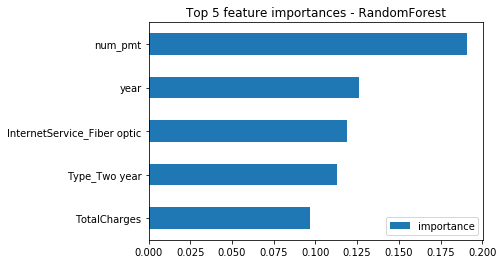

In [83]:
rf_feat_importance[:5].plot(kind='barh', y='importance')
plt.title('Top 5 feature importances - RandomForest')
plt.gca().invert_yaxis()

1) Contrast the LogisticRegression models' feature importance with that of RandomForest, and a completely
different picture emerges. Here the `Type`, `InternetService`, `num_pmt`, `TotalCharges` and `year` features are important. 
`num_pmt` is a derived feature.

Top 5 features for CatBoostClassifier model

In [84]:
cat_feat_importance = pd.DataFrame(best_cb2_model.feature_importances_, 
                                  index=features_train2.columns.tolist(), 
                                 ).sort_values(0, ascending=False).rename(columns={0: 'importance'})

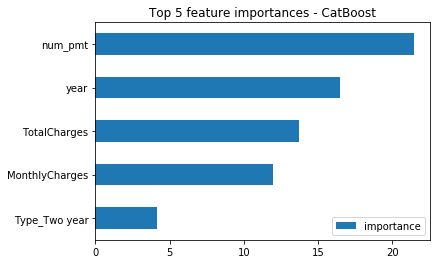

In [85]:
cat_feat_importance[:5].plot(kind='barh', y='importance')
plt.title('Top 5 feature importances - CatBoost')
plt.gca().invert_yaxis()

1) The CatBoost model has overfitted itself to the training. Some of the top features are similar to RandomForest. 

**Conclusion**

1) The tree based models clear differ from linear models in the way they identify important features. However, some
derived features such as `num_days` and `num_pmt` would be tricky to compute for a new customer, and therefore, based
on the insights the models has thrown, it makes sense to stick with LogisticRegression model.

**Summary**

1) The following custom features were engineered: a) `num_days` which is derived by taking the difference between `EndDate` and `BeginDate`. b) `num_pmt` derived by taking the ratio between `TotalCharges` and `MonthlyCharges`. c)
`num_services`, which counts a yes for a either a phone service or internet related service as 1 and a no as 0 - this is totalled to determine the number of services a customer has signed up for.

    2) A stratified 90:10 split was done to produce train and test sets. Based on previous feedback, the data leaking feature especially `num_pmt` along with `year`, `month` and `dayofweek` was resolved by dropping `month` and `dayofweek`.

3) Missing values in the phone and internet related features were replaced by 'No' as these represent customers who didn't avail these services.


4) Numerical features such as `MonthlyCharges` and `num_days`, `num_pmt`, `num_service` and `TotalCharges` were scaled on the training set. Similarly, the categorical features and binary features where encoded using one-hot encoding.


5) Redundant features such as `CustomerId`, `BeginDate` and `EndDate` were dropped and 4 models were built.

6) Leaky features such as `num_days` and `month` and `dayofweek` features created from `BeginDate` were removed.

7) Upsampling didn't help with improving the AUC ROC score. However, increasing the train test ratio from 80:20 to 90:10 did help the model improve by 1%.

7) 5-fold CV with Gridsearch was used to identify the suitable hyperparameters for the respective models. For example, in LogisticRegression `C` was tuned. For RandomForest, it was `n_estimators` and `max_depth`. `iterations`
was tuned for CatBoost.

8) The best model in terms of ROC-AUC and time to train the model is LogisticRegression with a AUC of 91% on the test set and a training time of 5 seconds.

9) The marketing team of the telco can use this model to identify churn. In addition, they can improve the signal
by adding features around usage of various plans, location of customer, customer complaints, time to resolve them, etc.


<div class="alert alert-danger">
    <s><b>Reviewer's comment</b><br>
    Great, you tried a couple of different models and the results look great, but unfortunately, due to a problem with target leakage the current test set scores may not represent the true generalization performance of the models. Please check the conclusions after fixing this
</div>

<div class="alert alert-success">
    <b>Reviewer's comment V2</b><br>
    I stated this in another comment above, but just wanted to reiterate this here: neither num_days, nor num_pmts are problematic by themselves, it's only in combination with the BeginDate (and/or its components) that they can be used to reconstruct the EndDate, which means target leakage. If the BeginDate and/or its components are removed, both num_days and num_pmts are great features!
</div>

**Note to reviewer**

If there was a need to link the solution report with the solution code that should have been mentioned in the 
instructions. Further, the platform should have been designed to open the existing project rather than open a new one.

### Solution Report

- What steps of the plan were performed and what steps were skipped (explain why)?
- What difficulties did you encounter and how did you manage to solve them?
- What were some of the key steps to solving the task?
- What is your final model and what quality score does it have?


**The following steps were performed:**

1) Exploratory analysis around gender, class of citizen and characteristics of the customers have revealed some useful insights into the behaviour of churned customers.

1.1) The mean monthly spend for a churned customer is higher by $13 compared with an active customer.

1.2) 1037(47%) of the customers who sign up do so within the first year of them churning.

1.3) Other behaviour noted among the churned customers are: a) customers with no dependents or partners tend to easily churn. b) Monthly billing gives them an easy exit option. c) Paperless billing and Fiber optic internet plan have been a thorn in retaining such customers.

2) The missing values in TotalCharges were imputed using SimpleImputer. Initially, I thought I would infer these values based on the MonthlyCharges, but I noticed that the monthly charges differ despite having the same usage duration and set of services. The resulting imputation didn't shift the median noticeably. I have also imputed the "missing" values for `MultipleLines` and various Internet services as I was under the assumption that they were missing at random. But, I was advised that this wasn't the case, so after merging the datasets, I filled them with a response of "No".

2.1) I skipped the idea of imputing missing values using LogisticRegression as this would have been overkill for this problem.

3) In the feature engineering step, I created num_day which is derived by taking the difference between EndDate and BeginDate. Additionally, I created num_pmt which is a ratio of TotalCharges/MonthlyCharges. num_services, which adds up the various services for a customer depending on whether they've answered "Yes" or "No". Date features such as year, month and dayofweek were extracted from BeginDate.

4) To avoid data leakage, I stratfied and split the dataset into train and test into a ratio of 80:20. I create a copy of this dataset, as I wanted to test whether num_days caused any leakage; I applied Oridinal Encoding for the `TypeandPaymentMethod` features.

4.1) I also scaled the numerical features such as num_days, num_pmt, num_services, MonthlyCharges, TotalCharges, including the date features.

4.2) I One-hot encoded the boolean features.

5) Excluding the Dummy model, I built 6 models using LogisticRegression, RandomForestClassifier and CatBoostClassifier. Each model was trained on the 2 datasets.

5.1) I used 5-fold cross validation during GridSearch to identify useful hyperparameters for the respective models. Only 1 or 2 hyperparameters were tuned to save time.

5.2) With leakage, the LogisticRegression model and CatBoost hit 99% AUC ROC on the test-set. Although the former completed 20x faster.

**Steps skipped**

1) Upsampling - because this only slightly improved the AUC, and after a point was causing the RandomForest and CatBoost to overfit to the train set.

2) num_days, month and dayofweek didn't have much signal strength relative to num_pmt and year.

3) Imputation - using LogisticRegression as this would have been overkill.


**Challenges**

1) The difficulties I encountered occurred after I removed the target leaked features such as num_days, num_pmt, year, month and dayofweek all in one go.

1.1) Based on the feedback received, I removed num_pmt, num_days and the Date features year, month and dayofweek, and retrained the model. This drastically reduced the score for LogisticRegression, which returned an AUC score 85%; the other models seem to overfit.

1.2) To address this, I added upsampling to the mix and changed the upsampling ratio, however, it only ended up overfitting the RandomForest and CatBoost models, and it helped the LogisticRegression models' AUC score to go up by 1%.

1.3) I changed the Ordinal features to use One-hot encoding, but that didn't help improve the performance.

1.4) I changed the train/test split to 90:10, and noticed a slight improvement.

1.5) I played with additional hyperparameters in RandomForest and CatBoost such as max_depth/depth, min_sample_leafs/l2_leaf_reg. min_sample_leafs helped reduce overfitting in RandomForest significantly, but l2_leaf_reg didn't help reduce overfitting. And a similar argument in CatBoost threw an error stating that the feature is not supported on CPU.

1.6) After more than an hour, I decided to reuse only month and dayofweek along with num_pmt and num_days. Surprisingly, this helped increase the AUC to 87% using LogisticRegression.

1.7) I dropped upsampling from the mix, and removed dayofweek to see if this would affect the score, but it didn't.

1.8) This time, I dropped month, dayofweek and num_days. I re-introduced year into the mix along with `num_pmt`, and this boosted my AUC score to 91% using LogisticRegression; The RandomForestClassifier's performance also improved with slight overfitting. However, CatBoost was severly overfitting although the AUC had improved on the test set.

1.9) What finally worked where the following: 1) increase the train-test split to 90:10, remove num_days, month, and dayofweek, and retain num_pmt and year with the other one-hot encoded features. Upsampling didn't help to improve the performance beyond this point.


**Key steps taken**

1) Feature engineering - Finding a golden feature which improves the signal to noise ratio helped me a lot.

2) Playing with train-test split also helped.

3) Avoiding leakage by splitting the data into train/test before scaling and applying ordinal enconding also helped.

4) Hyperparameter tuning along with 5-fold cross validation made me comfortable knowing that the model would generalize better to new data.

5) Not to forget, EDA also helped.


**Final model**

1) Because of the choice of features, I was able to build a simple model using LogisticRegression which achieved an AUC ROC score of 91% on the test set. This model took about 5 seconds to train, and didn't overfit either.
